In [1]:
#Bibliotecas utilizadas 

import pandas as pd 
from sklearn.model_selection import train_test_split  
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import preprocessing 
#from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder  

from sklearn.model_selection import cross_val_score

In [2]:
#carregando dados 
covid_alagoas = pd.read_excel("covid_alagoas.xlsx")  

In [3]:
#Exibição do dataset carregado
covid_alagoas.head() 

,Unnamed: 0,Data de atendimento no Serviço,IDADE,SEXO,MUNICÍPIO DE RESIDÊNCIA,classificacao,Comorbidades,"Situação do paciente confirmado (UTI, isolamento domiciliar, enfermaria) ?",Data do Óbito (Caso haja),Data de Confirmação do Exame
0,0,2020-03-26,1,F,MACEIÓ,CONFIRMADO,SEM COMORBIDADE,RECUPERADO,NaN,2020-04-13
1,1,2020-03-23,38,M,MACEIÓ,CONFIRMADO,DOENÇA PULMONAR CRÔNICA,RECUPERADO,NaN,2020-04-14
2,2,2020-04-06,35,M,MACEIÓ,CONFIRMADO,NaN,RECUPERADO,NaN,2020-04-14
3,3,2020-04-11,57,M,MACEIÓ,CONFIRMADO,NaN,RECUPERADO,NaN,2020-04-14
4,4,2020-04-27,60,M,MACEIÓ,CONFIRMADO,NaN,RECUPERADO,NaN,2020-04-14


## Tratamento dos dados / Pré processamento

In [4]:
# excluindo colunas que não serão utilizadas 
del covid_alagoas["Unnamed: 0"] 
del covid_alagoas["Data do Óbito (Caso haja)"] 
del covid_alagoas["Data de Confirmação do Exame"]   
del covid_alagoas["Data de atendimento no Serviço"]   

# Renomeando colunas
covid_alagoas = covid_alagoas.rename(columns={'Situação do paciente confirmado (UTI, isolamento domiciliar, enfermaria) ?': 'Situacao'}) 
covid_alagoas = covid_alagoas.rename(columns={'MUNICÍPIO DE RESIDÊNCIA': 'Municipio'})  

#Onde tem NaN na coluna de comorbidades está sendo substituído por sem comorbidade
covid_alagoas['Comorbidades'] = covid_alagoas.Comorbidades.fillna('SEM COMORBIDADE')

# A coluna de SEXO está sendo rotulada como 1 para masculina e 2 para feminino
covid_alagoas.loc[covid_alagoas.SEXO == 'M','SEXO'] = 1 
covid_alagoas.loc[covid_alagoas.SEXO == 'F','SEXO'] = 2 
covid_alagoas.loc[covid_alagoas.SEXO == 'Feminino','SEXO'] = 2 
covid_alagoas.loc[covid_alagoas.SEXO == 'f','SEXO'] = 2 
covid_alagoas.loc[covid_alagoas.SEXO == ' F','SEXO'] = 2



In [5]:
covid_alagoas.head() # Exibindo dataframe após tratamentos

,IDADE,SEXO,Municipio,classificacao,Comorbidades,Situacao
0,1,2,MACEIÓ,CONFIRMADO,SEM COMORBIDADE,RECUPERADO
1,38,1,MACEIÓ,CONFIRMADO,DOENÇA PULMONAR CRÔNICA,RECUPERADO
2,35,1,MACEIÓ,CONFIRMADO,SEM COMORBIDADE,RECUPERADO
3,57,1,MACEIÓ,CONFIRMADO,SEM COMORBIDADE,RECUPERADO
4,60,1,MACEIÓ,CONFIRMADO,SEM COMORBIDADE,RECUPERADO


In [6]:
#Rotulando comorbidades  

#Aqui a coluna de Comorbidades será rotulada com um valor único que se encontra na coluna rotulo_comorbidades

le = preprocessing.LabelEncoder() 
#le.fit_transform(covid_maceio['Comorbidades'].astype(str))
rotulo_comorbidades = le.fit_transform(covid_alagoas['Comorbidades'].astype(str))  
#covid_arapiraca['Comorbidades'] = le.fit_transform(covid_arapiraca['Comorbidades'].astype(str))   

rotulo_comorbidades.reshape(-1,1) #dimensionando array
# O array criado de rótulo de comorbidades será adicionado ao dataset 
covid_alagoas.loc[:,'rotulo_comorbidades'] = rotulo_comorbidades 

#exibindo dataframe após modificações
covid_alagoas.head()

,IDADE,SEXO,Municipio,classificacao,Comorbidades,Situacao,rotulo_comorbidades
0,1,2,MACEIÓ,CONFIRMADO,SEM COMORBIDADE,RECUPERADO,365
1,38,1,MACEIÓ,CONFIRMADO,DOENÇA PULMONAR CRÔNICA,RECUPERADO,224
2,35,1,MACEIÓ,CONFIRMADO,SEM COMORBIDADE,RECUPERADO,365
3,57,1,MACEIÓ,CONFIRMADO,SEM COMORBIDADE,RECUPERADO,365
4,60,1,MACEIÓ,CONFIRMADO,SEM COMORBIDADE,RECUPERADO,365


### Selecionando os datasets

In [7]:
#Aqui está sendo filtrado os dados referentes ao município de Maceió e Arapiraca 

covid_maceio = covid_alagoas.loc[covid_alagoas['Municipio'] == "MACEIÓ"] 
covid_arapiraca = covid_alagoas.loc[covid_alagoas['Municipio'] == "ARAPIRACA"]

In [8]:
print("Tamanho dos dataframes:",len(covid_arapiraca),len(covid_maceio)) 

Tamanho dos dataframes: 30901 88797


### Como há muitos mais dados de covid de Maceió em relação a Arapiraca, será selecionado uma amostra de mesmo tamanho de Arapiraca

In [9]:
#Extraindo amostra de dados
covid_maceio = covid_maceio.sample(30901)  

print("Tamanho dos dataframes agora:", len(covid_arapiraca),len(covid_maceio))

Tamanho dos dataframes agora: 30901 30901


### Selecionando dados de treino e teste

In [10]:
#selecionando as colunas que serão utilizadas para treinar e testar o modelo  

#para o dataset de Maceió 
X_maceio = covid_maceio[['IDADE','SEXO','rotulo_comorbidades']]
y_maceio = covid_maceio['Situacao']  

#para o dataset de Arapiraca 
X_arapiraca = covid_arapiraca[['IDADE','SEXO','rotulo_comorbidades']]
y_arapiraca = covid_arapiraca['Situacao'] 

In [11]:
# 70% doa dados serão usados para treino e 30% para teste 

#  P/ Maceió
X_train_maceio, X_test_maceio, y_train_maceio, y_test_maceio = train_test_split(X_maceio, y_maceio,test_size=0.3, random_state=0)  

# p/ Arapiraca  
X_train_arapiraca, X_test_arapiraca, y_train_arapiraca, y_test_arapiraca = train_test_split(X_arapiraca, y_arapiraca,test_size=0.3, random_state=0)  


In [12]:
knn = KNeighborsClassifier()  # Selecionando quantidade de vizinhos

In [13]:
maceio = knn.fit(X_train_maceio, y_train_maceio)  
arapiraca = knn.fit(X_train_arapiraca, y_train_arapiraca) 

In [14]:
# Estimando acurácia

#acuracia_maceio = knn.score(X_test_maceio, y_test_maceio) 
#acuracia_arapiraca = knn.score(X_test_arapiraca, y_test_arapiraca) 

#print("Acurácia para Maceió: ", acuracia_maceio) 
#print("Acurácia para Arapiraca: ", acuracia_arapiraca)

In [15]:
# criando dicionário (rotulando) as situações para ser utilizada na predição   
rotulo = dict(zip(covid_alagoas.Situacao.unique(), covid_alagoas.Situacao.unique()))   
rotulo

{'RECUPERADO': 'RECUPERADO',
 'ÓBITO': 'ÓBITO',
 'HOSPITALIZADO': 'HOSPITALIZADO',
 'Hospitalizado': 'Hospitalizado',
 'ÓBITO POR OUTRAS CAUSAS': 'ÓBITO POR OUTRAS CAUSAS',
 'ISOLAMENTO DOMICILIAR': 'ISOLAMENTO DOMICILIAR',
 'óbITO': 'óbITO'}

In [16]:
#Predição 

prediction_maceio = knn.predict(X_test_maceio) 
prediction_arapiraca = knn.predict(X_test_arapiraca)
#print("Situação do paciente: ", rotulo[prediction[0]])

## Avaliação do modelo para Maceió

In [17]:
#accuracy_score(y_test_maceio,prediction_maceio)

In [18]:
#matriz de confusão para Maceió 
print (pd.crosstab(y_test_maceio, prediction_maceio, rownames=['Real'], colnames=['Predito'], margins= False))

Predito                  HOSPITALIZADO  ISOLAMENTO DOMICILIAR  RECUPERADO  \
Real                                                                        
HOSPITALIZADO                        5                    317          44   
ISOLAMENTO DOMICILIAR               16                   3911         726   
RECUPERADO                          11                   3275         686   
ÓBITO                                0                     35          11   
ÓBITO POR OUTRAS CAUSAS              0                      1           0   

Predito                  ÓBITO  
Real                            
HOSPITALIZADO                0  
ISOLAMENTO DOMICILIAR        0  
RECUPERADO                  10  
ÓBITO                      221  
ÓBITO POR OUTRAS CAUSAS      2  


In [19]:
print("Relatório de classificação para Arapir: \n", classification_report(y_test_maceio, prediction_maceio)) 

C:\Users\Nelson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nelson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Relatório de classificação para Arapir: 
                          precision    recall  f1-score   support

          HOSPITALIZADO       0.16      0.01      0.03       366
  ISOLAMENTO DOMICILIAR       0.52      0.84      0.64      4653
             RECUPERADO       0.47      0.17      0.25      3982
                  ÓBITO       0.95      0.83      0.88       267
ÓBITO POR OUTRAS CAUSAS       0.00      0.00      0.00         3

               accuracy                           0.52      9271
              macro avg       0.42      0.37      0.36      9271
           weighted avg       0.49      0.52      0.46      9271



C:\Users\Nelson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Avaliação de modelo para Arapiraca


In [20]:
#print("Acurácia: ", accuracy_score(y_test_arapiraca,prediction_arapiraca))  
print (pd.crosstab(y_test_arapiraca, prediction_arapiraca, rownames=['Real'], colnames=['Predito'], margins= False)) 
print("Relatório de classificação: \n", classification_report(y_test_arapiraca, prediction_arapiraca)) 

Predito                  HOSPITALIZADO  ISOLAMENTO DOMICILIAR  RECUPERADO  \
Real                                                                        
HOSPITALIZADO                        0                    158          33   
ISOLAMENTO DOMICILIAR               20                   4893        1011   
RECUPERADO                           6                   2475         528   
ÓBITO                                2                     33           5   
ÓBITO POR OUTRAS CAUSAS              0                      1           0   

Predito                  ÓBITO  
Real                            
HOSPITALIZADO                0  
ISOLAMENTO DOMICILIAR        0  
RECUPERADO                   1  
ÓBITO                      105  
ÓBITO POR OUTRAS CAUSAS      0  


C:\Users\Nelson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nelson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Relatório de classificação: 
                          precision    recall  f1-score   support

          HOSPITALIZADO       0.00      0.00      0.00       191
  ISOLAMENTO DOMICILIAR       0.65      0.83      0.73      5924
             RECUPERADO       0.33      0.18      0.23      3010
                  ÓBITO       0.99      0.72      0.84       145
ÓBITO POR OUTRAS CAUSAS       0.00      0.00      0.00         1

               accuracy                           0.60      9271
              macro avg       0.39      0.35      0.36      9271
           weighted avg       0.54      0.60      0.55      9271



C:\Users\Nelson\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Testando validação cruzada

In [21]:
# TESTANDO A VALIDAÇÃO CRUZADA PARA MACEIÓ E ARAPIRACA

model_maceio = MLPClassifier(hidden_layer_sizes=(25, 25), max_iter=200, random_state=42)
model_maceio.fit(X_train_maceio, y_train_maceio)
print("Maceió:", model_maceio.score(X_train_maceio, y_train_maceio))  

model_arapiraca = MLPClassifier(hidden_layer_sizes=(25, 25), max_iter=200, random_state=42)
model_arapiraca.fit(X_train_arapiraca, y_train_arapiraca)
print("Arapiraca:", model_arapiraca.score(X_train_arapiraca, y_train_arapiraca))  



Maceió: 0.4507165973185391
Arapiraca: 0.6459546925566343


In [22]:
# CROSS VAL SCORE faz a validação cruzada e para cada validação ele calcula a acurácia de cada um
 

scores_maceio = cross_val_score(model_maceio, X_train_maceio, y_train_maceio, cv=10)
print("Maceió:",scores_maceio)   

scores_arapiraca = cross_val_score(model_arapiraca, X_train_arapiraca, y_train_arapiraca, cv=10)
print("Arapiraca:",scores_arapiraca) 


C:\Users\Nelson\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Maceió: [0.51132686 0.50855294 0.50947758 0.50947758 0.50947758 0.51317614
 0.50762829 0.50809061 0.45862228 0.50947758]


C:\Users\Nelson\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Arapiraca: [0.64678687 0.55755895 0.64678687 0.64586223 0.64493759 0.64724919
 0.64724919 0.64817383 0.64678687 0.6430883 ]


## Verificação do balanceamento dos dados

In [23]:
from sklearn.cluster import KMeans   
import matplotlib.pyplot as plt

In [24]:
covid_maceio.columns

Index(['IDADE', 'SEXO', 'Municipio', 'classificacao ', 'Comorbidades',
       'Situacao', 'rotulo_comorbidades'],
      dtype='object')

In [25]:
arrayIDADE = covid_maceio['IDADE'].values 
arrayIDADE = arrayIDADE.reshape(-1,1)

In [26]:
arrayIDADE = covid_maceio['IDADE'].values 
arrayIDADE = arrayIDADE.reshape(-1,1)
kmeansTx = KMeans(n_clusters=3).fit(arrayIDADE)
centroidsIDADE = kmeansTx.cluster_centers_
print(centroidsIDADE)

[[43.08587156]
 [24.19445445]
 [65.29474708]]


Text(0.5, 0, 'Idade')

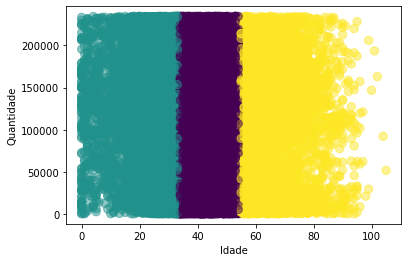

In [37]:
plt.scatter(arrayIDADE, covid_maceio.index, c= kmeansTx.labels_.astype(float), s=70, alpha=0.5) 
#plt.title("Idade") 
plt.ylabel("Quantidade") 
plt.xlabel("Idade")

[[1.]
 [2.]]


Text(0.5, 1.0, 'SEXO')

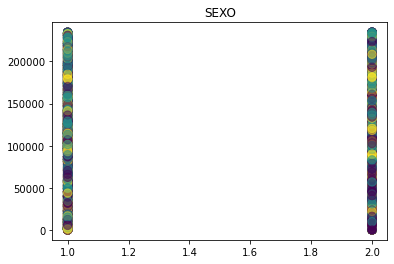

In [28]:
arraySEXO = covid_maceio['SEXO'].values 
arraySEXO = arraySEXO.reshape(-1,1)
kmeansSEXO = KMeans(n_clusters=2).fit(arraySEXO)
centroidsSEXO = kmeansSEXO.cluster_centers_
print(centroidsSEXO) 

plt.scatter(arraySEXO, covid_maceio.index, c= kmeansTx.labels_.astype(float), s=70, alpha=0.5) 
plt.title("SEXO")

In [29]:
arraySEXO = covid_maceio['classificacao'].values 
arraySEXO = arraySEXO.reshape(-1,1)
kmeansSEXO = KMeans(n_clusters=2).fit(arraySEXO)
centroidsSEXO = kmeansSEXO.cluster_centers_
print(centroidsSEXO) 

KeyError: 'classificacao'

In [ ]:
covid_maceio['Situacao'].values

array(['RECUPERADO', 'ISOLAMENTO DOMICILIAR', 'ÓBITO', ..., 'RECUPERADO',
       'RECUPERADO', 'ISOLAMENTO DOMICILIAR'], dtype=object)

In [ ]:
covid_maceio.head()

,IDADE,SEXO,Municipio,classificacao,Comorbidades,Situacao,rotulo_comorbidades
166133,23,2,MACEIÓ,CONFIRMADO,SEM COMORBIDADE,RECUPERADO,365
29170,46,2,MACEIÓ,CONFIRMADO,SEM COMORBIDADE,ISOLAMENTO DOMICILIAR,365
150346,44,2,MACEIÓ,CONFIRMADO,OBESIDADE,ÓBITO,331
98867,48,2,MACEIÓ,CONFIRMADO,SEM COMORBIDADE,ISOLAMENTO DOMICILIAR,365
161402,73,2,MACEIÓ,CONFIRMADO,HAS,ÓBITO,270
